# Hotel Booking

## 목차

### 1. EDA
서로 다른 두 호텔의 데이터가 포함되어 있다.

2015년 7월 1일부터 2017년 8월 31일 사이에 도착 예정의 예약 데이터들이 포함되어있다.  
(취소된 예약은 사용하지 않아야 실제 고객 데이터가 나온다.)

다루는 주제는

- 고객이 어디에서 오는지?
- 고객이 1박에 얼마를 지불하는지?
- 1년 동안 1박 요금의 변화?
- 가장 바쁜 달은?
- 사람들은 호텔에 얼마나 오래 머무르는지?
- 시장 부문별 예약
- 얼마나 많은 예약이 취소되었는지?
- 취소 건수가 가장 많은 달은?

# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = r"..\archive\hotel_bookings.csv"
full_data = pd.read_csv(file_path)

In [2]:
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

결측치 채우기

agent : 대리인. 대리인이 지정되지 않은 경우 대리인이 없이 예약이 이루어졌을 가능성이 높음

company : 없는 경우 비공개로 했을 가능성이 있음

In [4]:
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}        # 딕셔너리로 바꿔서 없는 값을 채워준다.
full_data_cln = full_data.fillna(nan_replacements)                                          # 결측치를 채워준다.

full_data_cln["meal"].replace("Undefined", "SC", inplace=True)                              # 식사 종류를 채워준다.

zero_guests = list(full_data_cln.loc[full_data_cln["adults"]                                # 성인, 소아, 유아의 값이 0인 경우를 리스트로 만들어준다.
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)                          # 리스트에 있는 값을 삭제한다.

In [5]:
# 데이터 상태 확인
full_data_cln.shape     # 데이터의 크기를 확인한다.

(119210, 32)

# 1. EDA

In [6]:
# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included. 
rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]        # 예약된 레스토랑 호텔을 뽑아낸다.
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

## 손님들이 어디서 오는가?

In [7]:
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"] == 0]["country"].value_counts()) # 예약된 국가를 뽑아낸다. 취소된 것은 제외한다.

#country_data.index.name = "country"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)  # 칼럼 이름을 바꾼다.
total_guests = country_data["Number of Guests"].sum()   # 총 예약자 수를 구한다.
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)  # 예약자 수를 퍼센트로 바꾼다.
country_data["country"] = country_data.index  # 인덱스를 국가로 바꾼다.
#country_data.loc[country_data["Guests in %"] < 2, "country"] = "Other"

# pie plot
fig = px.pie(country_data,                                  # 원형 그래프로 만든다.
             values="Number of Guests",                     # 값을 가져온다.
             names="country",                               # 이름을 가져온다.
             title="Home country of guests",                # 타이틀을 바꾼다.
             template="seaborn")                            # 스타일을 적용한다.
fig.update_traces(textposition="inside", textinfo="value+percent+label")        # 그래프 안에 값을 넣는다.
fig.show()                                                  # 그래프를 보여준다.

In [9]:
# show on map
guest_map = px.choropleth(country_data,                     # px.choropleth를 사용해서 지도를 만든다.
                    locations=country_data.index,           # 지도에 표시할 국가를 가져온다.
                    color=country_data["Guests in %"],      # 지도에 표시할 값을 가져온다.
                    hover_name=country_data.index,          # 툴팁에 표시할 값을 가져온다.
                    color_continuous_scale=px.colors.sequential.Plasma, # 색상을 지정한다.
                    title="Home country of guests")         # 타이틀을 바꾼다.
guest_map.show()                                            # 그래프를 보여준다.

> 대부분의 손님들은 유럽이나 포르투갈에서 주로 왔다.

## 손님들은 1박에 얼마를 지불하는가?

두 호텔 모두 객실 유형과 식사가 다르다. 계절적 요인도 가격에 중요하게 작용한다.

통화 정보는 없지만 포르투갈은 EMU에 속하므로 모두 유로로 표시한다고 가정한다.

In [10]:
# Counting adults and children as paying guests only, not babies.
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])      # rh에서 성인과 소아를 더한 값을 adr_pp에 넣는다.
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])      # ch에서 성인과 소아를 더한 값을 adr_pp에 넣는다.

C:\Users\esemo\AppData\Local\Temp\ipykernel_11660\4002143503.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\esemo\AppData\Local\Temp\ipykernel_11660\4002143503.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
print("""From all non-cnceled bookings, across all room types and meals, the average prices are: 
Resort hotel: {:.2f} € per night and person.
City hotel: {:.2f} € per night and person."""
      .format(rh["adr_pp"].mean(), ch["adr_pp"].mean()))          # 예약된 레스토랑 호텔의 가격을 평균으로 계산한다.

From all non-cnceled bookings, across all room types and meals, the average prices are: 
Resort hotel: 47.49 € per night and person.
City hotel: 59.27 € per night and person.


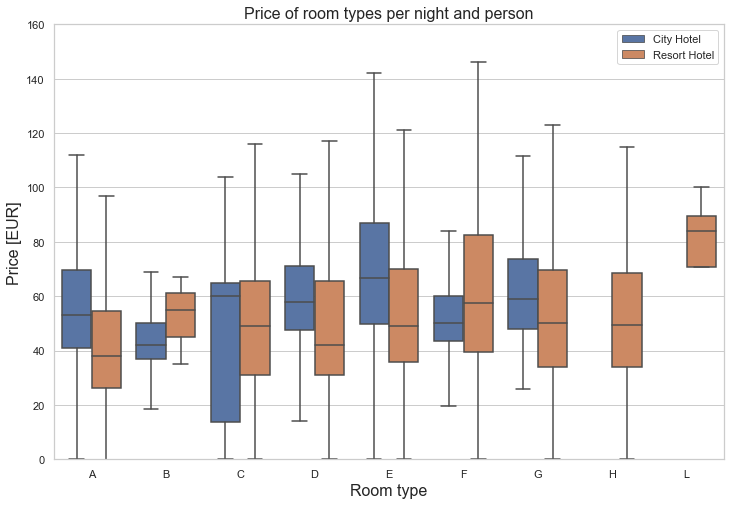

In [12]:
# normalize price per night (adr):
# 예약된 레스토랑 호텔의 가격을 정규화한다.
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"] + full_data_cln["children"])      # adr_pp에 정규화한 값을 넣는다.
full_data_guests = full_data_cln.loc[full_data_cln["is_canceled"] == 0] # 취소된 것은 제외한다.
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type") # 예약된 방 종류에 따라 정렬한다.

# boxplot:
plt.figure(figsize=(12, 8))             # 그래프의 크기를 설정한다.
sns.boxplot(x="reserved_room_type",     # x축을 방 종류로 설정한다.
            y="adr_pp",                 # y축을 가격으로 설정한다.
            hue="hotel",                # hue를 호텔명으로 설정한다.
            data=room_prices,           # 데이터를 설정한다.
            hue_order=["City Hotel", "Resort Hotel"],       # 호텔명을 설정한다.
            fliersize=0)                # 플리어 크기를 설정한다.
plt.title("Price of room types per night and person", fontsize=16)      # 타이틀을 설정한다.
plt.xlabel("Room type", fontsize=16)    # x축 라벨을 설정한다.
plt.ylabel("Price [EUR]", fontsize=16)  # y축 라벨을 설정한다.
plt.legend(loc="upper right")           # 범례를 설정한다.
plt.ylim(0, 160)                        # y축의 범위를 설정한다.
plt.show()                              # 그래프를 보여준다.

방의 종류에 따라서 표준편자를 따라 방당 평균 가격이 다르다.

## 1년 동안의 1박 비용의 변화
룸타입과 식사에 상관없이 1박 1인당 평균 가격을 사용하고 있다.

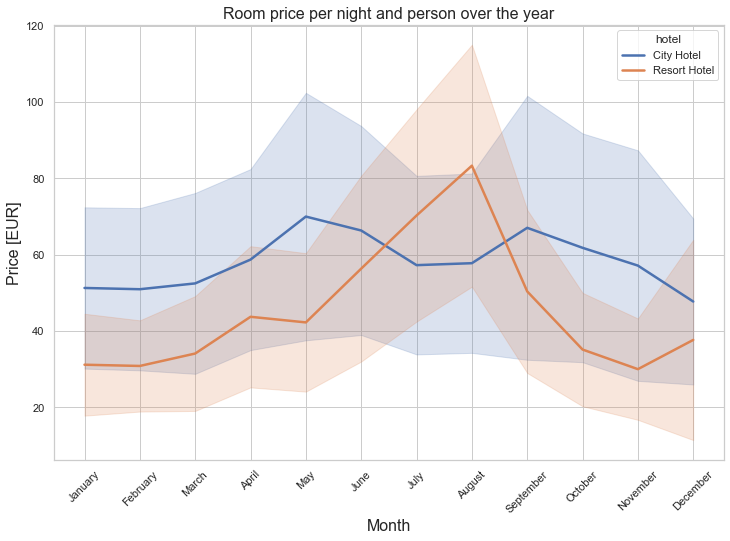

In [13]:
# grab data:
room_prices_mothly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")  # 도착 날짜에 따라 정렬한다.

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June",           # 리스트에 월 정렬 기준을 넣는다.
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True) # 리스트에 따라 정렬한다.

# barplot with standard deviation:
plt.figure(figsize=(12, 8))             # 그래프의 크기를 설정한다.
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_mothly,    # x축을 도착 날짜와 y축을 가격으로 설정한다. hue를 호텔명으로 설정한다. data를 설정한다.
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16) # 타이틀을 설정한다.
plt.xlabel("Month", fontsize=16)    # x축 라벨을 설정한다.
plt.xticks(rotation=45) # x축 라벨을 45도 회전시킨다.
plt.ylabel("Price [EUR]", fontsize=16)  # y축 라벨을 설정한다.
plt.show() # 그래프를 보여준다.

여름에 확실히 Resort 호텔의 가격이 높다.

City호텔의 가격은 변동이 적고 봄과 가을에 가장 비싸다.

## 언제가 가장 바쁜 달인가?

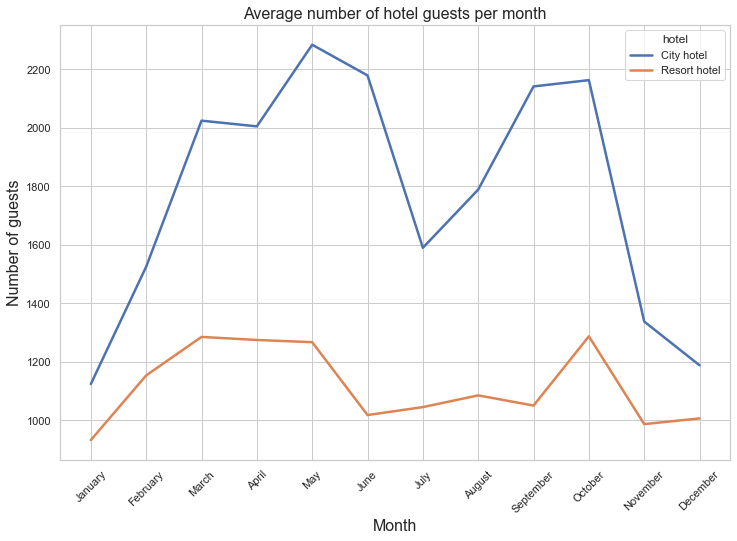

In [14]:
# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

City호텔은 가격도 제일 비싼 봄과 가을에 손님이 제일 많다.  
7월과 8월에는 가격이 저렴하지만 방문객이 적다. (성수기엔 사람 많이 몰리고 그만큼 가격도 높음)

Resort호텔은 가격이 가장 높은 6월에서 9월까지 전체적으로 약간 감소한다.

두 호텔 모두 겨울에 손님이 가장 적다.

## How long do people stay at the hotels?

In [15]:
# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

C:\Users\esemo\AppData\Local\Temp\ipykernel_11660\2828700948.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\esemo\AppData\Local\Temp\ipykernel_11660\2828700948.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



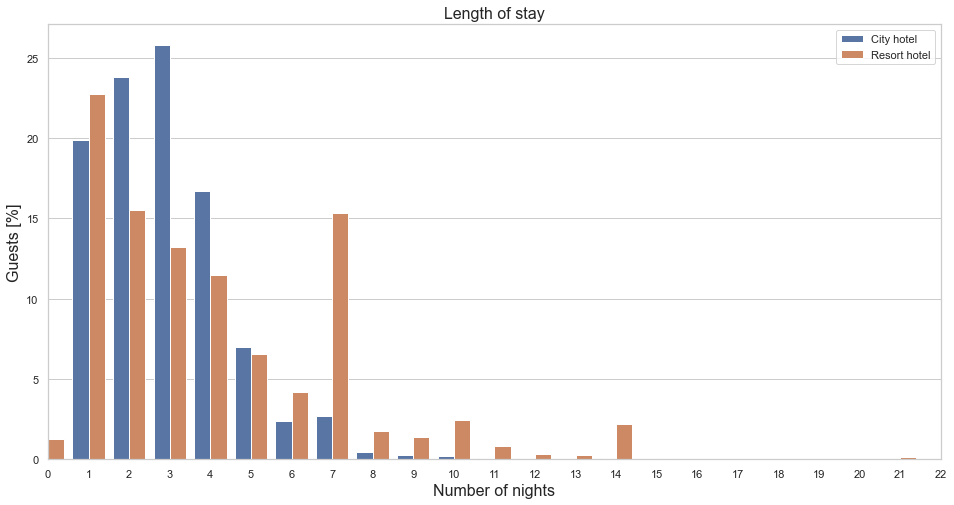

In [16]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [17]:
avg_nights_res = sum(list((res_nights["num_nights"] * (res_nights["rel_num_bookings"]/100)).values))
avg_nights_cty = sum(list((cty_nights["num_nights"] * (cty_nights["rel_num_bookings"]/100)).values))
print(f"On average, guests of the City hotel stay {avg_nights_cty:.2f} nights, and {cty_nights['num_nights'].max()} at maximum.")
print(f"On average, guests of the Resort hotel stay {avg_nights_res:.2f} nights, and {res_nights['num_nights'].max()} at maximum.")

On average, guests of the City hotel stay 2.92 nights, and 48 at maximum.
On average, guests of the Resort hotel stay 4.14 nights, and 69 at maximum.


City 호텔의 경우 1-4박을 선호한다.  

Resort 호텔의 경우 1~4박도 예약이 많이 되지만 7박도 인기가 많은 편이다.

## Bookings by market segment

In [18]:
# total bookings per market segment (incl. canceled)
segments=full_data_cln["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

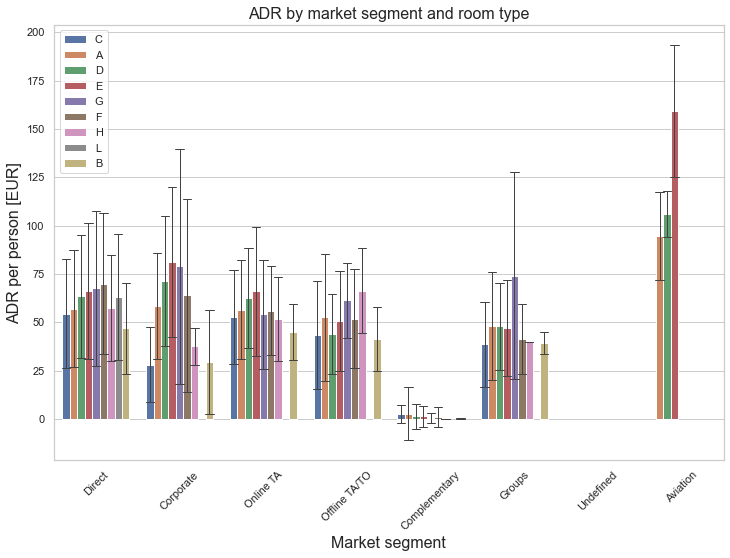

In [19]:
# price per night (ADR) and person based on booking and room.
# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x="market_segment",
            y="adr_pp",
            hue="reserved_room_type",
            data=full_data_cln,
            ci="sd",
            errwidth=1,
            capsize=0.1)
plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

평균적으로 단체는 가장 좋은 가격을 받고 항공사는 약 두 배의 비용을 지불한다.

항공사가 높은 가격을 지불하는게 가능한 이유는 무엇일까?

In [20]:
# Summarize Relevant data:
Airline_data = full_data_cln.loc[full_data_cln["market_segment"]== "Aviation"][["is_canceled",
                                                                                "adults",
                                                                                "lead_time",
                                                                                "adr_pp",]].describe()

Non_Airline_data = full_data_cln.loc[full_data_cln["market_segment"]!= "Aviation"][["is_canceled",
                                                                                    "adults",
                                                                                    "lead_time",
                                                                                    "adr_pp",]].describe()

In [21]:
Airline_data

,is_canceled,adults,lead_time,adr_pp
count,235.000000,235.000000,235.00000,235.000000
mean,0.221277,1.012766,4.47234,100.270979
std,0.415992,0.112503,4.61629,20.376689
min,0.000000,1.000000,0.00000,0.000000
25%,0.000000,1.000000,1.00000,95.000000
50%,0.000000,1.000000,3.00000,95.000000
75%,0.000000,1.000000,6.00000,110.000000
max,1.000000,2.000000,23.00000,193.500000


In [22]:
Non_Airline_data

,is_canceled,adults,lead_time,adr_pp
count,118975.000000,118975.000000,118975.000000,118971.000000
mean,0.371061,1.860878,104.306031,55.038212
std,0.483091,0.574499,106.888885,29.016998
min,0.000000,0.000000,0.000000,-3.190000
25%,0.000000,2.000000,18.000000,37.440000
50%,0.000000,2.000000,69.000000,49.500000
75%,1.000000,2.000000,161.000000,66.000000
max,1.000000,55.000000,737.000000,2700.000000


항공사에서는 승무원이 머물 곳이 필요한데, 항공사는 1인당 1개의 방을 얻으며, 가족에 비해 더 많은 객실이 필요하게 된다.

## 얼마나 많은 예약이 취소되었는가?

In [23]:
# absolute cancelations:
total_cancelations = full_data_cln["is_canceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


## 어느 달에 가장 많이 취소되었는가?

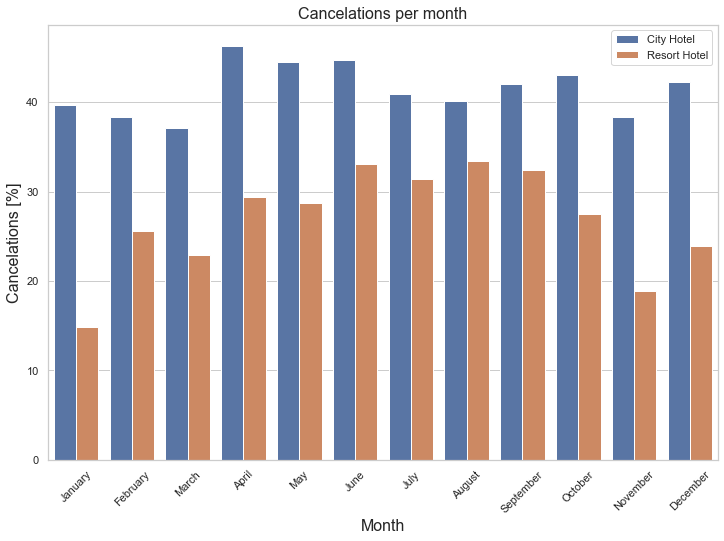

In [24]:
# Create a DateFrame with the relevant data:
res_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

City 호텔의 경우 상대적인 취소 비율은 일년 내내 약 40%이다.

Resort 호텔의 경우 여름에 가장 높고 겨울에 가장 낮다.